In [2]:
%load_ext autoreload
%autoreload 2
from finlab import data,backtest
import finlab
import pandas as pd
import matplotlib.pyplot as plt
from finlab.backtest import sim
from finlab.dataframe import FinlabDataFrame
import pickle
from finlab.plot import plot_tw_stock_candles,plot_tw_stock_treemap
import plotly.express as px
from finlab.tools.event_study import create_factor_data
import tqdm
import numpy as np 
import sys 
import mplfinance as mpf
import os
import plotly.graph_objects as go
import cufflinks as cf
from sklearn.linear_model import LinearRegression
import statistics 
import warnings
import time
from concurrent.futures import ThreadPoolExecutor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
# 忽略所有警告
warnings.filterwarnings("ignore")


# 自己寫的小工具

sys.path.append("../utils"),sys.path.append("..") # 導入上級目錄

from co_tools import co_event_analysis,often_use_list,co_event_analysis_real_trade,co_trade_visual,co_get_all_kbar
from co_tools2 import Codata
from finlab_token import token

In [3]:
#付費版token
finlab.login(token())

#初始化
db_path = "/home/sb0487/trade/finlab/finlab_db/"
cget = Codata(db_path,auto_update = True,df_type = "findf").get


spark = SparkSession.builder.appName("Pandas to Spark DataFrame").getOrCreate()

輸入成功!
初始化...
當前日資料最新日期為:2024-02-20 00:00:00
當前月資料最新日期為:2024-02-15 00:00:00
當前季資料最新日期為:2023-Q4


24/02/21 12:53:17 WARN Utils: Your hostname, wyym resolves to a loopback address: 127.0.1.1; using 172.28.225.79 instead (on interface eth0)
24/02/21 12:53:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/21 12:53:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/21 12:53:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 載入資料

In [8]:
disposal_information = data.get('disposal_information').sort_index()
close = data.get('price:收盤價')
monthly_revenue = data.get('monthly_revenue:當月營收')


# 條件

In [9]:
#將不是分盤交易的處置雜訊過濾
#分盤
# disposal_information = disposal_information[disposal_information["分時交易"]==20.0].dropna(how='all')

#第N次處置
# disposal_information = disposal_information[disposal_information["處置措施"]=="第二次處置"].dropna(how='all')


disposal_information = disposal_information[~disposal_information["分時交易"].isna()].dropna(how='all')
disposal_information = disposal_information.reset_index()[["stock_id","處置開始時間","處置結束時間"]]
disposal_information.columns = ["stock_id","處置開始時間","處置結束時間"]
disposal_information = disposal_information[disposal_information['stock_id'].astype(str).apply(len) == 4]
#去除DR股
filtered_disposal_information = disposal_information[~disposal_information['stock_id'].astype(str).str.startswith('91')]
#選擇從2018年以後的資料
filtered_disposal_information = filtered_disposal_information[filtered_disposal_information['處置開始時間'] >= '2018-01-01']

In [35]:
#初始位置，將全部股票的position設為0，後續產生持有部位使用
## 用迴圈將處置時間內改成true
cond1 = close < 0 
for i in range(0,filtered_disposal_information.shape[0]):
    stock_id = filtered_disposal_information.iloc[i,0]
    start_day = filtered_disposal_information.iloc[i,1]+ pd.Timedelta(days=1)
    end_day = filtered_disposal_information.iloc[i,2]- pd.Timedelta(days=1)
    #處置時間期間持有
    cond1.loc[start_day:end_day,stock_id] = True


#營收成長率
rev_yoy = monthly_revenue/monthly_revenue.shift(12)
rev_mom = monthly_revenue/monthly_revenue.shift(1)
cond2 =  rev_yoy>1.1 #年增率
# cond3 =  rev_mom>1#月增率


conds = cond1 & cond2 &cond3

In [36]:
report = sim(conds,trade_at_price="open",fee_ratio=1.425/1000*0.6, position_limit=.5, name='')

# 查看交易紀錄

In [37]:
report_df = report.get_trades()
print("交易筆數",len(report_df))
print("平均報酬率",report_df["return"].mean())
print("平均持有期間",report_df["period"].mean())

交易筆數 662
平均報酬率 0.046849808463869956
平均持有期間 7.427492447129909


In [11]:
all_trades.tail(50)

NameError: name 'all_trades' is not defined

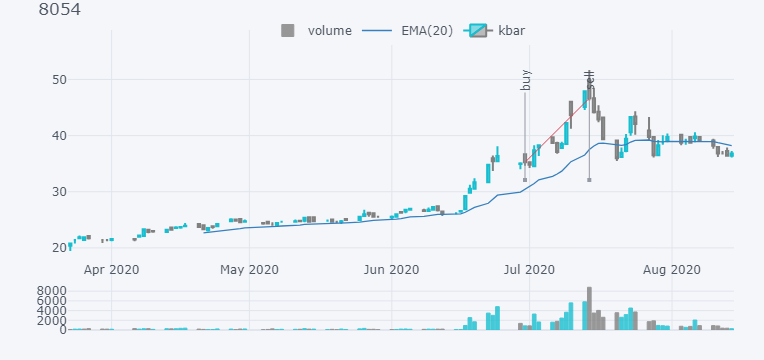

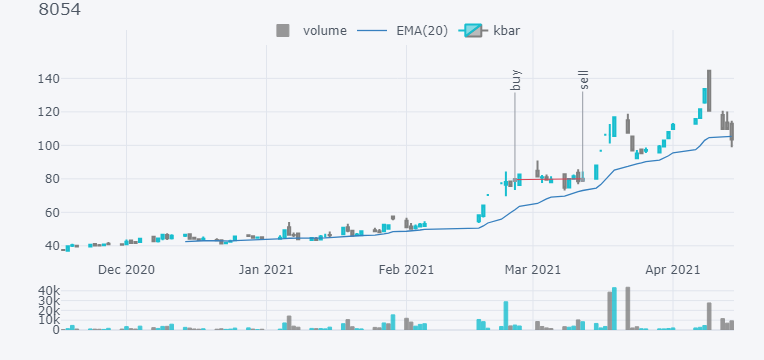

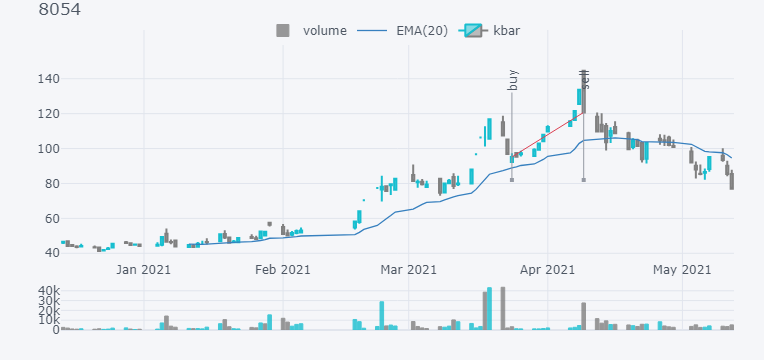

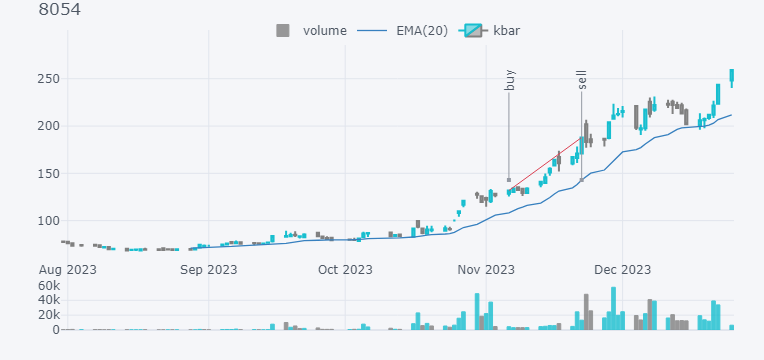

ValueError: NaTType does not support strftime

In [35]:
stock_name = "8054"
co_trade_visual(stock_name,all_trades,kbar_df,100)